In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, Lasso, LassoCV, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from dmba import load_data
from dmba.metrics import regression_summary

In [2]:
car_df = load_data("ToyotaCorolla.csv")
car_df = car_df.iloc[:1000]
car_df.head(3)

,id,model,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,...,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,parking_assistant,tow_bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0


In [3]:
predictors = [
    "age_08_04",
    "km",
    "fuel_type",
    "hp",
    "met_color",
    "automatic",
    "cc",
    "doors",
    "quarterly_tax",
    "weight",
]
outcome = "price"

In [4]:
# Partition data.
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [5]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

LinearRegression()

In [6]:
# Print coefficients
print(pd.DataFrame({"Predictor": X.columns, "coefficient": car_lm.coef_}))

           Predictor  coefficient
0          age_08_04  -140.748761
1                 km    -0.017840
2                 hp    36.103419
3          met_color    84.281830
4          automatic   416.781954
5                 cc     0.017737
6              doors   -50.657863
7      quarterly_tax    13.625325
8             weight    13.038711
9   fuel_type_Diesel  1066.464681
10  fuel_type_Petrol  2310.249543


In [7]:
# Print performance measures (training data)
regression_summary(train_y, car_lm.predict(train_X))

RMSE: 1961630.8093020304
MAE: 1046.9071608220581


In [8]:
regression_summary(test_y, car_lm.predict(test_X))

RMSE: 1723581.0830504769
MAE: 1017.5971544783305


<AxesSubplot:>

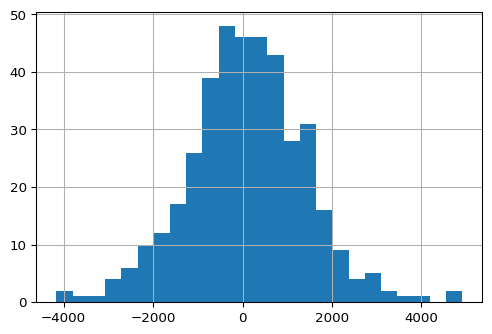

In [9]:
car_lm_pred = car_lm.predict(test_X)
result = pd.DataFrame(
    {"Predicted": car_lm_pred, "Actual": test_y, "Residual": test_y - car_lm_pred}
)
result.Residual.hist(bins=25)

## Variable selection in Linear Regression

Goal is to reduce the number of predictors. This can be done by:

1) exhaustive search
2) popular subset selection algorithms, e.g. forward selection or backward elimination
3) regularization (shrinkage models)

In [10]:
from dmba.feature_selection import (
    backward_elimination,
    exhaustive_search,
    forward_selection,
)
from dmba.metrics import AIC_score, adjusted_r2_score

In [11]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model


def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # We negate as score is optimized to be as low as possible.
    return -adjusted_r2_score(train_y, pred_y, model)

In [12]:
all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model, score_model)

data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result["variables"] for var in all_variables})
    data.append(d)
pd.DataFrame(data, columns=("n", "r2adj", "AIC") + tuple(sorted(all_variables)))

,n,r2adj,AIC,age_08_04,automatic,cc,doors,fuel_type_Diesel,fuel_type_Petrol,hp,km,met_color,quarterly_tax,weight
0,1,0.767901,10689.712094,True,False,False,False,False,False,False,False,False,False,False
1,2,0.801160,10597.910645,True,False,False,False,False,False,True,False,False,False,False
2,3,0.829659,10506.084235,True,False,False,False,False,False,True,False,False,False,True
3,4,0.846357,10445.174820,True,False,False,False,False,False,True,True,False,False,True
4,5,0.849044,10435.578836,True,False,False,False,False,False,True,True,False,True,True
5,6,0.853172,10419.932278,True,False,False,False,False,True,True,True,False,True,True
6,7,0.853860,10418.104025,True,False,False,False,True,True,True,True,False,True,True
7,8,0.854297,10417.290103,True,True,False,False,True,True,True,True,False,True,True
8,9,0.854172,10418.789079,True,True,False,True,True,True,True,True,False,True,True
9,10,0.854036,10420.330800,True,True,False,True,True,True,True,True,True,True,True


## Backward elimination for reducint predictors in Toyota Corolla example.

In [13]:
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


all_variables = train_X.columns
best_model, best_variables = backward_elimination(
    all_variables, train_model, score_model, verbose=True
)
best_variables

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=10422.30
Step: score=10420.33, remove cc
Step: score=10418.79, remove met_color
Step: score=10417.29, remove doors
Step: score=10417.29, remove None


['age_08_04',
 'km',
 'hp',
 'automatic',
 'quarterly_tax',
 'weight',
 'fuel_type_Diesel',
 'fuel_type_Petrol']

## Forward selection for reducing predictors in Toyota Corolla example

In [14]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model


def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)

    return AIC_score(train_y, model.predict(train_X[variables]), model)

In [15]:
best_model, best_variables = forward_selection(
    train_X.columns, train_model, score_model, verbose=True
)
best_variables

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add age_08_04
Step: score=10597.91, add hp
Step: score=10506.08, add weight
Step: score=10445.17, add km
Step: score=10435.58, add quarterly_tax
Step: score=10419.93, add fuel_type_Petrol
Step: score=10418.10, add fuel_type_Diesel
Step: score=10417.29, add automatic
Step: score=10417.29, add None


['age_08_04',
 'hp',
 'weight',
 'km',
 'quarterly_tax',
 'fuel_type_Petrol',
 'fuel_type_Diesel',
 'automatic']

## Lasso and ridge regression applied to the Toyota Corolla data

In [16]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)

regression_summary(test_y, lasso.predict(test_X))

RMSE: 1774957.2408091961
MAE: 1021.528640113914


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [17]:
# Normalize was deprecated.
# About alpha: Set parameter alpha to: original_alpha * np.sqrt(n_samples).
model = make_pipeline(StandardScaler(), Lasso(alpha=1 * np.sqrt(train_X.shape[0])))
model.fit(train_X, train_y)
regression_summary(test_y, model.predict(test_X))

RMSE: 1774957.2408091968
MAE: 1021.5286401139142


In [18]:
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)

regression_summary(test_y, lasso_cv.predict(test_X))

RMSE: 1954243.972047438
MAE: 1052.4649480069947


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [19]:
model = make_pipeline(StandardScaler(), LassoCV(cv=5))
model.fit(train_X, train_y)

regression_summary(test_y, model.predict(test_X))

RMSE: 1851570.7472926485
MAE: 1034.4870757255942


In [20]:
model.score(test_X, test_y)

0.8729299076648035

In [21]:
print("Lasso-CV chosen regularization:", lasso_cv.alpha_)
print(lasso_cv.coef_)

Lasso-CV chosen regularization: 3.5138446691310588
[-1.40370575e+02 -1.76669006e-02  3.38674037e+01  0.00000000e+00
  6.94393427e+01  0.00000000e+00  0.00000000e+00  2.70913468e+00
  1.24342596e+01 -0.00000000e+00  0.00000000e+00]


In [22]:
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)

regression_summary(test_y, ridge.predict(test_X))

RMSE: 3533432.228487325
MAE: 1353.2735295225127


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [23]:
ridge = make_pipeline(StandardScaler(), Ridge(alpha=1 * train_X.shape[0]))
ridge.fit(train_X, train_y)

regression_summary(test_y, ridge.predict(test_X))

RMSE: 3533432.228487328
MAE: 1353.2735295225139


In [24]:
bayesian_ridge = BayesianRidge(normalize=True)
bayesian_ridge.fit(train_X, train_y)

regression_summary(test_y, bayesian_ridge.predict(test_X))

RMSE: 1724026.016262425
MAE: 1017.2355887928646


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [25]:
alpha = bayesian_ridge.lambda_ / bayesian_ridge.alpha_
print("Bayesian ridge chosen regularization", alpha)

Bayesian ridge chosen regularization 0.004622833439968838


In [26]:
pipeline = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())
pipeline.fit(train_X, train_y)

regression_summary(test_y, pipeline.predict(test_X))

RMSE: 1724026.0162625185
MAE: 1017.2355887928262


In [27]:
pipeline.steps

[('standardscaler', StandardScaler(with_mean=False)),
 ('bayesianridge', BayesianRidge())]

In [28]:
bayesian_ridge = pipeline.named_steps["bayesianridge"]
alpha = bayesian_ridge.lambda_ / bayesian_ridge.alpha_
print("Bayesian ridge chosen regularization", alpha)

Bayesian ridge chosen regularization 2.7737000643214036


In [29]:
from sklearn.feature_selection import SequentialFeatureSelector

est = LinearRegression()
sfs = SequentialFeatureSelector(est, n_features_to_select="auto")

sfs.fit(train_X, train_y)

SequentialFeatureSelector(estimator=LinearRegression(),
                          n_features_to_select='auto')

In [30]:
pd.DataFrame({"use_feature": sfs.get_support(), "columns": train_X.columns})

,use_feature,columns
0,True,age_08_04
1,True,km
2,True,hp
3,False,met_color
4,False,automatic
5,False,cc
6,False,doors
7,True,quarterly_tax
8,True,weight
9,False,fuel_type_Diesel


In [31]:
print("Selected features:", sum(sfs.get_support()))

Selected features: 5


In [32]:
train_X.columns[sfs.get_support(indices=True)]

Index(['age_08_04', 'km', 'hp', 'quarterly_tax', 'weight'], dtype='object')

In [33]:
est.fit(sfs.transform(train_X), train_y)

LinearRegression()

In [34]:
regression_summary(train_y, est.predict(sfs.transform(train_X)))

RMSE: 2046048.6305092645
MAE: 1073.5948711397605


In [35]:
regression_summary(test_y, est.predict(sfs.transform(test_X)))

RMSE: 1829860.70875033
MAE: 1040.5094879352307


In [36]:
AIC_score(train_y, est.predict(sfs.transform(train_X)), est)

10435.578836118764

In [37]:
est.coef_

array([-1.39371420e+02, -2.09177447e-02,  4.11478042e+01,  6.63974451e+00,
        1.21318286e+01])